## make a copy on your google drive, do not edit this notebook

In [1]:
%matplotlib inline

In [2]:
!python --version

Python 3.8.10


In [3]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

/home/yin/.local/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.xavier_normal_(m.weight)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

Importing the Dataset
---------------------

import cifar10 dataset



In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

batch_size = 256

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = [str(i) for i in range(10)]


In [7]:
for batch_idx, (data, target) in enumerate(train_loader):
    print(data.shape)
    break

torch.Size([256, 1, 28, 28])


In [8]:
IN_dim = 28*28
T = 20

Define the Network
------------------

<!-- For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in `this paper <https://arxiv.org/pdf/1610.00087.pdf>`__. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms. -->




In [9]:
"""
Liquid time constant snn
"""
import os
import shutil
import torch
from torch import nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch.nn import init
from torch.autograd import Variable
import math
def create_exp_dir(path, scripts_to_save=None):
    if not os.path.exists(path):
        os.mkdir(path)

    print('Experiment dir : {}'.format(path))
    if scripts_to_save is not None:
        os.mkdir(os.path.join(path, 'scripts'))
        for script in scripts_to_save:
            dst_file = os.path.join(path, 'scripts', os.path.basename(script))
            shutil.copyfile(script, dst_file)
            

def model_save(fn, model, criterion, optimizer):
    with open(fn, 'wb') as f:
        torch.save([model, criterion, optimizer], f)

def model_load(fn):
    with open(fn, 'rb') as f:
        model, criterion, optimizer = torch.load(f)
    return model, criterion, optimizer

def save_checkpoint(state, is_best, prefix, filename='_rec2_bias_checkpoint.pth.tar'):
    print('saving at ', prefix+filename)
    torch.save(state, prefix+filename)
    if is_best:
        shutil.copyfile(prefix+filename, prefix+ '_rec2_bias_model_best.pth.tar')


def count_parameters(model):
    return sum(p.numel() for p in model.network.parameters() if p.requires_grad)

###############################################################################################
###############################    Define SNN layer   #########################################
###############################################################################################
N_pop = 10

b_j0 = 0.01  # neural threshold baseline
R_m = 3  # membrane resistance
dt = 1  
gamma = .5  # gradient scale
lens = 0.5

def gaussian(x, mu=0., sigma=.5):
    return torch.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / torch.sqrt(2 * torch.tensor(math.pi)) / sigma


class ActFun_adp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):  # input = membrane potential- threshold
        ctx.save_for_backward(input)
        return input.gt(0).float()  # is firing ???

    @staticmethod
    def backward(ctx, grad_output):  # approximate the gradients
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # temp = abs(input) < lens
        scale = 6.0
        hight = .15
        # temp = torch.exp(-(input**2)/(2*lens**2))/torch.sqrt(2*torch.tensor(math.pi))/lens
        temp = gaussian(input, mu=0., sigma=lens) * (1. + hight) \
               - gaussian(input, mu=lens, sigma=scale * lens) * hight \
               - gaussian(input, mu=-lens, sigma=scale * lens) * hight
        # temp =  gaussian(input, mu=0., sigma=lens)
        return grad_input * temp.float() #* gamma
        # return grad_input


act_fun_adp = ActFun_adp.apply

# def mem_update_adp(inputs, mem, spike, tau_adp,tau_m, b, dt=1, isAdapt=0):
#     alpha = tau_m
    
#     ro = tau_adp
#     # alpha = torch.exp(-1. * dt / tau_m).cuda()
#     # ro = torch.exp(-1. * dt / tau_adp).cuda()

#     if isAdapt:
#         beta = .18
#     else:
#         beta = 0.

#     b = ro * b + (1 - ro) * spike
#     B = b_j0 + beta * b
    

#     d_mem = -mem + inputs
#     mem = mem + d_mem*alpha
#     inputs_ = mem - B

#     spike = act_fun_adp(inputs_)  # act_fun : approximation firing function
#     mem = (1-spike)*mem

#     return mem, spike, B, b

def mem_update_adp(inputs, mem, spike, tau_adp, tau_m,b, dt=1, isAdapt=1):
    # alpha = torch.exp(-1. * dt / tau_m).cuda()
    # ro = torch.exp(-1. * dt / tau_adp).cuda()
    alpha = tau_m
    ro = tau_adp
    if isAdapt:
        beta = 1.8
    else:
        beta = 0.
    b = ro * b + (1. - ro) * spike
    B = b_j0 + beta * b

    mem = mem * alpha + (1 - alpha) * R_m * inputs #- B * spike * dt
    inputs_ = mem - B
    spike = act_fun_adp(inputs_)  # act_fun : approximation firing function
    # spike = F.relu(inputs)
    mem = (1-spike)*mem
    return mem, spike, B, b


def output_Neuron(inputs, mem, tau_m, dt=1):
    """
    The read out neuron is leaky integrator without spike
    """
    d_mem = -mem  +  inputs
    mem = mem+inputs*tau_m
    return mem


###############################################################################################
###############################################################################################
###############################################################################################
class SNN_rec_cell(nn.Module):
    def __init__(self, input_size, hidden_size,is_rec = False,is_LTC=False):
        super(SNN_rec_cell, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.is_rec = is_rec
        self.is_LTC = is_LTC
        

        if is_rec:
            self.layer1_x = nn.Linear(input_size, hidden_size)
            self.layer1_r = nn.Linear(hidden_size, hidden_size)

        else:
            self.layer1_x = nn.Linear(input_size, hidden_size)
            
        
        # time-constant definiation and initilization 
        if is_LTC:
            self.layer1_tauAdp = nn.Linear(2*hidden_size, hidden_size)
            self.layer1_tauM = nn.Linear(2*hidden_size, hidden_size)
            nn.init.xavier_uniform_(self.layer1_tauAdp.weight)
            nn.init.xavier_uniform_(self.layer1_tauM.weight)
        else:
            self.tau_adp = nn.Parameter(torch.Tensor(hidden_size))
            self.tau_m =nn.Parameter(torch.Tensor(hidden_size))
            nn.init.normal_(self.tau_adp, 4.8,.1)
            nn.init.normal_(self.tau_m, 3.,.1)
            # nn.init.constant_(self.tau_adp, 200)
            # nn.init.constant_(self.tau_m, 20)
        self.act1 = nn.Sigmoid()
        self.act2 = nn.Sigmoid()

        
    
        nn.init.xavier_uniform_(self.layer1_x.weight)
        if is_rec: nn.init.xavier_uniform_(self.layer1_r.weight)
        

    def forward(self, x_t, mem_t,spk_t,b_t,is_dirI=False):    
        if self.is_rec:
            if is_dirI:
                dense_x = x_t + self.layer1_r(spk_t)
            else:
                dense_x = self.layer1_x(x_t) + self.layer1_r(spk_t) 
        else:
            dense_x = self.layer1_x(x_t)

        if self.is_LTC:
            tauM1 = self.act1(self.layer1_tauM(torch.cat((dense_x,mem_t),dim=-1)))
            tauAdp1 = self.act1(self.layer1_tauAdp(torch.cat((dense_x,b_t),dim=-1)))
        else:
            tauM1 = self.act1(self.tau_m)
            tauAdp1 = self.act2(self.tau_adp)
            # tauM1 = self.tau_m
            # tauAdp1 = self.tau_adp

        mem_1,spk_1,_,b_1 = mem_update_adp(dense_x, mem=mem_t,spike=spk_t,
                                        tau_adp=tauAdp1,tau_m=tauM1,b =b_t)

        return mem_1,spk_1,b_1

    def compute_output_size(self):
        return [self.hidden_size]

class SNN(nn.Module):
    def __init__(self, input_size, hidden_size,output_size,is_LTC=False):
        super(SNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.output_size = output_size
        
        self.convs = nn.Sequential(nn.Conv2d(1,16,3),
                                nn.BatchNorm2d(16),
                                nn.ReLU(),
                                nn.Conv2d(16,16,3),
                                nn.BatchNorm2d(16),
                                nn.ReLU(),
                                nn.Conv2d(16,16,3,1,1),
                                nn.BatchNorm2d(16),
                                nn.ReLU(),
                                nn.MaxPool2d(2),
                                
                                nn.Conv2d(16,32,3),
                                nn.BatchNorm2d(32),
                                nn.ReLU(),
                                nn.Conv2d(32,32,3),
                                nn.BatchNorm2d(32),
                                nn.ReLU(),
                                nn.Conv2d(32,32,3,1,1),
                                nn.BatchNorm2d(32),
                                nn.ReLU(),
                                nn.MaxPool2d(2)
                                )

        self.rnn_name = 'SNN: is_LTC-'+str(is_LTC)

        self.snn_h = SNN_rec_cell(input_size,hidden_size,False,is_LTC)

        self.snn_r = SNN_rec_cell(hidden_size,hidden_size,True,is_LTC)

        self.snn_p = SNN_rec_cell(hidden_size,10*N_pop,True,is_LTC)
        self.p2r = nn.Linear(10*N_pop,hidden_size)
        nn.init.constant_(self.p2r.weight,0.)

        self.bridge1 = nn.Linear(10*N_pop,hidden_size)

        self.snn_r2 = SNN_rec_cell(hidden_size,hidden_size,True,is_LTC)

        self.snn_p2 = SNN_rec_cell(hidden_size,10*N_pop,True,is_LTC)
        self.p2r_2 = nn.Linear(10*N_pop,hidden_size)
        # nn.init.constant_(self.p2r_2.weight,0.)
        nn.init.xavier_normal(self.p2r_2.weight)
    
        self.tau_m_o = nn.Parameter(torch.Tensor(output_size))

        nn.init.constant_(self.tau_m_o, 0.5)
        # nn.init.xavier_uniform_(self.layer3_x.weight)
        # nn.init.zeros_(self.layer3_tauM.weight)
        self.act3 = nn.Sigmoid()
    

        self.dp1 = nn.Dropout(0.1)#.1
        self.dp2 = nn.Dropout(0.1)
        self.dp3 = nn.Dropout(0.1)
        self.fr = 0
        
    def forward(self, inputs, h):
        
        
        # outputs = []
        hiddens = []
 
        b,_,d1,d2,= inputs.shape
        t = 1
        for x_i in range(t):
            x_down = inputs.float()#reshape(b,self.input_size).float()
            x_down =  F.dropout(x_down,0.2,training=True)
            x_down = self.convs(x_down).view(b,-1)
            # print(x_down.shape)

            mem_h,spk_h,b_h = self.snn_h(x_down, mem_t=h[0],spk_t=h[1],b_t = h[2])
            
            r_input = x_down + self.p2r(h[7])
            mem_r,spk_r,b_r = self.snn_r(r_input, mem_t=h[3],spk_t=h[4],b_t = h[5],is_dirI=True)
            p_input = spk_r
            mem_p,spk_p,b_p = self.snn_p(p_input, mem_t=h[6],spk_t=h[7],b_t = h[8])

            r_input2 = self.bridge1(spk_p) + self.p2r_2(h[13])
            mem_r2,spk_r2,b_r2 = self.snn_r2(r_input2, mem_t=h[9],spk_t=h[10],b_t = h[11],is_dirI=True)
            p_input2 = spk_r2
            mem_p2,spk_p2,b_p2 = self.snn_p2(p_input2, mem_t=h[12],spk_t=h[13],b_t = h[14])

       
            dense3_x_avg = F.avg_pool1d(spk_p2.reshape(-1,1,10*N_pop),N_pop,N_pop)[:,0,:]
          
            tauM2 = self.tau_m_o
            mem_out = output_Neuron(dense3_x_avg,mem=h[-2],tau_m = tauM2)

            out =mem_out
            self.fr = self.fr+ spk_h.detach().cpu().numpy().mean()/2.\
                + spk_r.detach().cpu().numpy().mean()/2.

        h = (mem_h,spk_h,b_h, 
            mem_r,spk_r,b_r, 
            mem_p,spk_p,b_p, 
            mem_r2,spk_r2,b_r2, 
            mem_p2,spk_p2,b_p2, 
            mem_out,
            out)

        f_output = F.log_softmax(out, dim=1)
        hiddens.append(h)

        
        final_state = h
        return f_output, final_state, hiddens

class SeqModel(nn.Module):
    def __init__(self, ninp, nhid, nout,is_rec=True,is_LTC = True):

        super(SeqModel, self).__init__()
        self.nout = nout    # Should be the number of classes
        self.nhid = nhid
        self.is_rec = is_rec
        self.is_LTC= is_LTC

        self.network = SNN(input_size=ninp, hidden_size=nhid, output_size=nout)
        

    def forward(self, inputs, hidden):
      
        t = T
        # print(inputs.shape) # L,B,d
        outputs = []
        for i in range(t):
            f_output, hidden, hiddens= self.network.forward(inputs, hidden)
            outputs.append(f_output)
        return outputs, hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters()).data
        return (weight.new(bsz,self.nhid).uniform_(),
                weight.new(bsz,self.nhid).zero_(),
                weight.new(bsz,self.nhid).fill_(b_j0),
                # representation
                weight.new(bsz,self.nhid).zero_(),
                weight.new(bsz,self.nhid).zero_(),
                weight.new(bsz,self.nhid).fill_(b_j0),
                # prediction
                weight.new(bsz,10*N_pop).zero_(),
                weight.new(bsz,10*N_pop).zero_(),
                weight.new(bsz,10*N_pop).fill_(b_j0),
                # representation2
                weight.new(bsz,self.nhid).zero_(),
                weight.new(bsz,self.nhid).zero_(),
                weight.new(bsz,self.nhid).fill_(b_j0),
                # prediction2
                weight.new(bsz,10*N_pop).zero_(),
                weight.new(bsz,10*N_pop).zero_(),
                weight.new(bsz,10*N_pop).fill_(b_j0),
                # layer out
                weight.new(bsz,self.nout).uniform_(),
                # sum spike
                weight.new(bsz,self.nout).zero_(),
                )




### cat instead of sum

In [10]:
# """
# Liquid time constant snn
# """
# import os
# import shutil
# import torch
# from torch import nn
# from torch.nn.parameter import Parameter
# import torch.nn.functional as F
# from torch.nn import init
# from torch.autograd import Variable
# import math
# def create_exp_dir(path, scripts_to_save=None):
#     if not os.path.exists(path):
#         os.mkdir(path)

#     print('Experiment dir : {}'.format(path))
#     if scripts_to_save is not None:
#         os.mkdir(os.path.join(path, 'scripts'))
#         for script in scripts_to_save:
#             dst_file = os.path.join(path, 'scripts', os.path.basename(script))
#             shutil.copyfile(script, dst_file)
            

# def model_save(fn, model, criterion, optimizer):
#     with open(fn, 'wb') as f:
#         torch.save([model, criterion, optimizer], f)

# def model_load(fn):
#     with open(fn, 'rb') as f:
#         model, criterion, optimizer = torch.load(f)
#     return model, criterion, optimizer

# def save_checkpoint(state, is_best, prefix, filename='_rec2_bias_checkpoint.pth.tar'):
#     print('saving at ', prefix+filename)
#     torch.save(state, prefix+filename)
#     if is_best:
#         shutil.copyfile(prefix+filename, prefix+ '_rec2_bias_model_best.pth.tar')


# def count_parameters(model):
#     return sum(p.numel() for p in model.network.parameters() if p.requires_grad)

# ###############################################################################################
# ###############################    Define SNN layer   #########################################
# ###############################################################################################
# N_pop = 10

# b_j0 = 0.01  # neural threshold baseline
# R_m = 1  # membrane resistance
# dt = 1  
# gamma = .5  # gradient scale
# lens = 0.5

# def gaussian(x, mu=0., sigma=.5):
#     return torch.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / torch.sqrt(2 * torch.tensor(math.pi)) / sigma


# class ActFun_adp(torch.autograd.Function):
#     @staticmethod
#     def forward(ctx, input):  # input = membrane potential- threshold
#         ctx.save_for_backward(input)
#         return input.gt(0).float()  # is firing ???

#     @staticmethod
#     def backward(ctx, grad_output):  # approximate the gradients
#         input, = ctx.saved_tensors
#         grad_input = grad_output.clone()
#         # temp = abs(input) < lens
#         scale = 6.0
#         hight = .15
#         # temp = torch.exp(-(input**2)/(2*lens**2))/torch.sqrt(2*torch.tensor(math.pi))/lens
#         temp = gaussian(input, mu=0., sigma=lens) * (1. + hight) \
#                - gaussian(input, mu=lens, sigma=scale * lens) * hight \
#                - gaussian(input, mu=-lens, sigma=scale * lens) * hight
#         # temp =  gaussian(input, mu=0., sigma=lens)
#         return grad_input * temp.float() #* gamma
#         # return grad_input


# act_fun_adp = ActFun_adp.apply

# # def mem_update_adp(inputs, mem, spike, tau_adp,tau_m, b, dt=1, isAdapt=0):
# #     alpha = tau_m
    
# #     ro = tau_adp
# #     # alpha = torch.exp(-1. * dt / tau_m).cuda()
# #     # ro = torch.exp(-1. * dt / tau_adp).cuda()

# #     if isAdapt:
# #         beta = .18
# #     else:
# #         beta = 0.

# #     b = ro * b + (1 - ro) * spike
# #     B = b_j0 + beta * b
    

# #     d_mem = -mem + inputs
# #     mem = mem + d_mem*alpha
# #     inputs_ = mem - B

# #     spike = act_fun_adp(inputs_)  # act_fun : approximation firing function
# #     mem = (1-spike)*mem

# #     return mem, spike, B, b

# def mem_update_adp(inputs, mem, spike, tau_adp, tau_m,b, dt=1, isAdapt=1):
#     # alpha = torch.exp(-1. * dt / tau_m).cuda()
#     # ro = torch.exp(-1. * dt / tau_adp).cuda()
#     alpha = tau_m
#     ro = tau_adp
#     if isAdapt:
#         beta = 1.8
#     else:
#         beta = 0.
#     b = ro * b + (1. - ro) * spike
#     B = b_j0 + beta * b

#     mem = mem * alpha + (1 - alpha) * R_m * inputs #- B * spike * dt
#     inputs_ = mem - B
#     spike = act_fun_adp(inputs_)  # act_fun : approximation firing function
#     # spike = F.relu(inputs_)
#     mem = (1-spike)*mem
#     return mem, spike, B, b


# def output_Neuron(inputs, mem, tau_m, dt=1):
#     """
#     The read out neuron is leaky integrator without spike
#     """
#     d_mem = -mem  +  inputs
#     mem = mem+inputs*tau_m
#     return mem


# ###############################################################################################
# ###############################################################################################
# ###############################################################################################
# class SNN_rec_cell(nn.Module):
#     def __init__(self, input_size, hidden_size,is_rec = False,is_LTC=False):
#         super(SNN_rec_cell, self).__init__()
        
#         self.input_size = input_size
#         self.hidden_size = hidden_size 
#         self.is_rec = is_rec
#         self.is_LTC = is_LTC
        

#         if is_rec:
#             self.layer1_x = nn.Linear(input_size, hidden_size)
#             self.layer1_r = nn.Linear(hidden_size, hidden_size)

#         else:
#             self.layer1_x = nn.Linear(input_size, hidden_size)
            
        
#         # time-constant definiation and initilization 
#         if is_LTC:
#             self.layer1_tauAdp = nn.Linear(2*hidden_size, hidden_size)
#             self.layer1_tauM = nn.Linear(2*hidden_size, hidden_size)
#             nn.init.xavier_uniform_(self.layer1_tauAdp.weight)
#             nn.init.xavier_uniform_(self.layer1_tauM.weight)
#         else:
#             self.tau_adp = nn.Parameter(torch.Tensor(hidden_size))
#             self.tau_m =nn.Parameter(torch.Tensor(hidden_size))
#             nn.init.normal_(self.tau_adp, 4.8,.1)
#             nn.init.normal_(self.tau_m, 3.,.1)
#             # nn.init.constant_(self.tau_adp, 200)
#             # nn.init.constant_(self.tau_m, 20)
#         self.act1 = nn.Sigmoid()
#         self.act2 = nn.Sigmoid()

        
    
#         nn.init.xavier_uniform_(self.layer1_x.weight)
#         if is_rec: nn.init.xavier_uniform_(self.layer1_r.weight)
        

#     def forward(self, x_t, mem_t,spk_t,b_t):    
#         if self.is_rec:
#             # print(x_t.shape,spk_t.shape)
#             dense_x = self.layer1_x(x_t) + self.layer1_r(spk_t) 
#         else:
#             dense_x = self.layer1_x(x_t)

#         if self.is_LTC:
#             tauM1 = self.act1(self.layer1_tauM(torch.cat((dense_x,mem_t),dim=-1)))
#             tauAdp1 = self.act1(self.layer1_tauAdp(torch.cat((dense_x,b_t),dim=-1)))
#         else:
#             tauM1 = self.act1(self.tau_m)
#             tauAdp1 = self.act2(self.tau_adp)
#             # tauM1 = self.tau_m
#             # tauAdp1 = self.tau_adp

#         mem_1,spk_1,_,b_1 = mem_update_adp(dense_x, mem=mem_t,spike=spk_t,
#                                         tau_adp=tauAdp1,tau_m=tauM1,b =b_t)

#         return mem_1,spk_1,b_1

#     def compute_output_size(self):
#         return [self.hidden_size]

# class SNN(nn.Module):
#     def __init__(self, input_size, hidden_size,output_size,is_LTC=False):
#         super(SNN, self).__init__()
        
#         self.input_size = input_size
#         self.hidden_size = hidden_size 
#         self.output_size = output_size
        
#         self.rnn_name = 'SNN: is_LTC-'+str(is_LTC)

#         self.convs = nn.Sequential(nn.Conv2d(1,16,3),
#                                 nn.BatchNorm2d(16),
#                                 nn.ReLU(),
#                                 nn.Conv2d(16,16,3),
#                                 nn.BatchNorm2d(16),
#                                 nn.ReLU(),
#                                 nn.MaxPool2d(2),
                                
#                                 nn.Conv2d(16,32,3),
#                                 nn.BatchNorm2d(32),
#                                 nn.ReLU(),
#                                 nn.Conv2d(32,32,3),
#                                 nn.BatchNorm2d(32),
#                                 nn.ReLU(),
#                                 nn.MaxPool2d(2)
#                                 )

#         self.snn_h = SNN_rec_cell(input_size,hidden_size,False,is_LTC)

#         self.snn_r = SNN_rec_cell(hidden_size+10*N_pop,hidden_size,True,is_LTC)
#         self.snn_p = SNN_rec_cell(hidden_size,10*N_pop,True,is_LTC)
#         # self.p2r = nn.Linear(10*N_pop,hidden_size)
#         # nn.init.constant_(self.p2r.weight,0.)

#         self.snn_r2 = SNN_rec_cell(20*N_pop,hidden_size,True,is_LTC)
#         self.snn_p2 = SNN_rec_cell(hidden_size,10*N_pop,True,is_LTC)
#         # self.p2r_2 = nn.Linear(10*N_pop,hidden_size)
#         # # nn.init.constant_(self.p2r_2.weight,0.)
#         # nn.init.xavier_normal(self.p2r_2.weight)
    
#         self.tau_m_o = nn.Parameter(torch.Tensor(output_size))

#         nn.init.constant_(self.tau_m_o, 0.5)
#         # nn.init.xavier_uniform_(self.layer3_x.weight)
#         # nn.init.zeros_(self.layer3_tauM.weight)
#         self.act3 = nn.Sigmoid()
    

#         self.dp1 = nn.Dropout(0.1)#.1
#         self.dp2 = nn.Dropout(0.1)
#         self.dp3 = nn.Dropout(0.1)
#         self.fr = 0
        
#     def forward(self, inputs, h):
        
        
#         # outputs = []
#         hiddens = []
 
#         b,in_dim,d1,d2= inputs.shape
#         t = 1
#         for x_i in range(t):
#             x_down = inputs.float()#reshape(b,self.input_size).float()
#             # x_down =  F.dropout(x_down,0.2,training=True)
#             x_down = self.convs(x_down).view(b,-1)
#             # print(x_down.shape)

#             mem_h,spk_h,b_h = self.snn_h(x_down, mem_t=h[0],spk_t=h[1],b_t = h[2])
            
#             r_input = torch.cat((x_down,h[7]),dim=-1)#spk_h + self.p2r(h[7])
#             mem_r,spk_r,b_r = self.snn_r(r_input, mem_t=h[3],spk_t=h[4],b_t = h[5])
#             p_input = spk_r
#             mem_p,spk_p,b_p = self.snn_p(p_input, mem_t=h[6],spk_t=h[7],b_t = h[8])

#             r_input2 = torch.cat((spk_p,h[13]),dim=-1)#-self.p2r(spk_p) + self.p2r_2(h[13])
#             # print('r: ',r_input.shape,r_input2.shape)
#             mem_r2,spk_r2,b_r2 = self.snn_r2(r_input2, mem_t=h[9],spk_t=h[10],b_t = h[11])
#             p_input2 = spk_r2
#             mem_p2,spk_p2,b_p2 = self.snn_p2(p_input2, mem_t=h[12],spk_t=h[13],b_t = h[14])

       
#             dense3_x_avg = F.avg_pool1d(spk_p2.reshape(-1,1,10*N_pop),N_pop,N_pop)[:,0,:]
          
#             tauM2 = self.tau_m_o
#             mem_out = output_Neuron(dense3_x_avg,mem=h[-2],tau_m = tauM2)

#             out =mem_out
#             self.fr = self.fr+ spk_r2.detach().cpu().numpy().mean()/2.\
#                 + spk_r.detach().cpu().numpy().mean()/2.

#         h = (mem_h,spk_h,b_h, 
#             mem_r,spk_r,b_r, 
#             mem_p,spk_p,b_p, 
#             mem_r2,spk_r2,b_r2, 
#             mem_p2,spk_p2,b_p2, 
#             mem_out,
#             out)

#         f_output = F.log_softmax(out, dim=1)
#         hiddens.append(h)

        
#         final_state = h
#         return f_output, final_state, hiddens

# class SeqModel(nn.Module):
#     def __init__(self, ninp, nhid, nout,is_rec=True,is_LTC = True):

#         super(SeqModel, self).__init__()
#         self.nout = nout    # Should be the number of classes
#         self.nhid = nhid
#         self.is_rec = is_rec
#         self.is_LTC= is_LTC

#         self.network = SNN(input_size=ninp, hidden_size=nhid, output_size=nout)
        

#     def forward(self, inputs, hidden):
      
#         t = T
#         # print(inputs.shape) # L,B,d
#         outputs = []
#         for i in range(t):
#             f_output, hidden, hiddens= self.network.forward(inputs, hidden)
#             outputs.append(f_output)
#         return outputs, hidden

#     def init_hidden(self, bsz):
#         weight = next(self.parameters()).data
#         return (weight.new(bsz,self.nhid).uniform_(),
#                 weight.new(bsz,self.nhid).zero_(),
#                 weight.new(bsz,self.nhid).fill_(b_j0),
#                 # representation
#                 weight.new(bsz,self.nhid).zero_(),
#                 weight.new(bsz,self.nhid).zero_(),
#                 weight.new(bsz,self.nhid).fill_(b_j0),
#                 # prediction
#                 weight.new(bsz,10*N_pop).zero_(),
#                 weight.new(bsz,10*N_pop).zero_(),
#                 weight.new(bsz,10*N_pop).fill_(b_j0),
#                 # representation2
#                 weight.new(bsz,self.nhid).zero_(),
#                 weight.new(bsz,self.nhid).zero_(),
#                 weight.new(bsz,self.nhid).fill_(b_j0),
#                 # prediction2
#                 weight.new(bsz,10*N_pop).zero_(),
#                 weight.new(bsz,10*N_pop).zero_(),
#                 weight.new(bsz,10*N_pop).fill_(b_j0),
#                 # layer out
#                 weight.new(bsz,self.nout).uniform_(),
#                 # sum spike
#                 weight.new(bsz,self.nout).zero_(),
#                 )




## FPTT function:

In [11]:
# fptt parameters
alpha = .5
beta = .5
rho = 0.

In [12]:
def get_stats_named_params( model ):
    named_params = {}
    for name, param in model.named_parameters():
        sm, lm, dm = param.detach().clone(), 0.0*param.detach().clone(), 0.0*param.detach().clone()
        named_params[name] = (param, sm, lm, dm)
    return named_params

def post_optimizer_updates( named_params):
    for name in named_params:
        param, sm, lm, dm = named_params[name]
        lm.data.add_( -alpha * (param - sm) )
        sm.data.mul_( (1.0-beta) )
        sm.data.add_( beta * param - (beta/alpha) * lm )

def get_regularizer_named_params( named_params,  _lambda=1.0 ):
    regularization = torch.zeros( [], device=device )
    for name in named_params:
        param, sm, lm, dm = named_params[name]
        regularization += (rho-1.) * torch.sum( param * lm )
        r_p = _lambda * 0.5 * alpha * torch.sum( torch.square(param - sm) )
        regularization += r_p
        # print(name,r_p)
    return regularization 

def reset_named_params(named_params):
    for name in named_params:
        param, sm, lm, dm = named_params[name]
        param.data.copy_(sm.data)

## test function

In [13]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    # for data, target in test_loader:
    for i ,(data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(-1, 1,28,28)
        with torch.no_grad():
            model.eval()
            hidden = model.init_hidden(data.size(0))
        
            outputs, hidden= model(data, hidden) 
           
            output = outputs[-1]
            # output = torch.stack(outputs[-10:]).mean(dim=0)
            
            test_loss += F.nll_loss(output, target, reduction='sum').data.item()
            pred = output.data.max(1, keepdim=True)[1]
        
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        torch.cuda.empty_cache()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
           test_loss, correct, len(test_loader.dataset),
           100. * correct / len(test_loader.dataset)))
    return test_loss, 100. * correct / len(test_loader.dataset)

## training function

In [14]:
# training parameters
K  = T# sequence length
omega = int(T/K)
clip = 1.
log_interval = 100
lr = 1e-3

In [15]:

def train(train_loader, n_classes, model, named_params,epoch,optimizer):
    global steps
    global estimate_class_distribution

    train_loss = 0
    total_clf_loss = 0
    total_regularizaton_loss = 0
    total_oracle_loss = 0
    model.train()


    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(-1, 1,28,28)
       
        B = target.size()[0]
        fr_sum = 0
        for p in range(T):

            if p==0:
                h = model.init_hidden(data.size(0))
            elif p%omega==0:
                h = tuple(v.detach() for v in h)

            # print([p.shape for p in h])
            if p<K-1:
                if epoch < 10:
                    oracle_prob = 0*estimate_class_distribution[target, p] + (1.0/n_classes)
                else:
                    oracle_prob = estimate_class_distribution[target, p]
            else:
                oracle_prob = F.one_hot(target,n_classes).float() 

            
            o, h,hs = model.network.forward(data, h )
            fr_sum += model.network.fr

            prob_out = F.softmax(h[-1], dim=1)
            output = F.log_softmax(h[-1], dim=1) 

            
            if p<K-1:
                with torch.no_grad():
                    filled_class = [0]*n_classes
                    n_filled = 0
                    for j in range(B):
                        if n_filled==n_classes: break
                        y = target[j].item()
                        if filled_class[y] == 0 and (torch.argmax(prob_out[j]) != target[j]):
                            filled_class[y] = 1
                            estimate_class_distribution[y, p] = prob_out[j].detach()
                            n_filled += 1
            if p%omega==0 and p>0: 
                optimizer.zero_grad()
                
                # clf_loss = (p+1)/(K)*F.nll_loss(output, target)
                clf_loss = F.nll_loss(output, target)
     
        
                oracle_loss = 1.0 *torch.mean( -oracle_prob.to(device) * output )
                # oracle_loss = (1 - (p+1)/(K)) *torch.mean(torch.mean( -oracle_prob.to(device) * output,axis=1)*snr)
                    
                regularizer = get_regularizer_named_params( named_params, _lambda=1.0 )      
                loss = clf_loss  + regularizer  + oracle_loss

                loss.backward()

                if clip > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

                # if batch_idx > 0 and batch_idx % log_interval == 0 and p == 10:
                #     print('i2h',model.network.snn_h.layer1_x.weight.grad.data.mean())
                #     print('h2r',model.network.snn_r.layer1_x.weight.grad.data.mean())
                #     print('r2p',model.network.snn_p.layer1_x.weight.grad.data.mean())
      

                optimizer.step()
                post_optimizer_updates( named_params)
            
                train_loss += loss.item()
                total_clf_loss += clf_loss.item()
                total_regularizaton_loss += regularizer #.item()
                total_oracle_loss += oracle_loss.item()
        
        
        if batch_idx > 0 and batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tlr: {:.6f}\tLoss: {:.6f}\tOracle: \
                {:.6f}\tClf: {:.6f}\tReg: {:.6f}\tFr: {:.6f}'.format(
                   epoch, batch_idx * batch_size, len(train_loader.dataset),
                   100. * batch_idx / len(train_loader), lr, train_loss / log_interval, 
                   total_oracle_loss / log_interval, 
                   total_clf_loss / log_interval, total_regularizaton_loss / log_interval, fr_sum/T/log_interval))
            
            train_loss = 0
            total_clf_loss = 0
            total_regularizaton_loss = 0
            total_oracle_loss = 0
        model.network.fr = 0
            


In [16]:
n_classes = 10

In [17]:
model = SeqModel(ninp=512,
                    nhid=512,
                    nout=n_classes)
model.to(device)
model.apply(weights_init)
total_params = count_parameters(model)

<ipython-input-9-1ffb3f97324e>:248: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.p2r_2.weight)


In [18]:
optimizer = optim.Adam(model.parameters(), lr=lr)#, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)  # reduce the learning after 20 epochs by a factor of 10

In [19]:
# w_init = model.network.snn3.h2r.weight.detach().cpu().numpy()

Training and Testing the Network
--------------------------------

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.

In [20]:
test_loss, acc1 = test( model, test_loader )


Test set: Average loss: 2.4001, Accuracy: 1087/10000 (11%)



In [21]:
epochs = 30
named_params = get_stats_named_params( model )
prefix ='save name'
all_test_losses = []
best_acc1 = 20

estimate_class_distribution = torch.zeros(n_classes, T, n_classes, dtype=torch.float)
for epoch in range(epochs):
    train(train_loader, n_classes, model, named_params,epoch,optimizer)   

    reset_named_params(named_params)


    test_loss, acc1 = test( model, test_loader )


    scheduler.step()

        
    # remember best acc@1 and save checkpoint
    is_best = acc1 > best_acc1
    best_acc1 = max(acc1, best_acc1)
        
    # save_checkpoint({
    #         'epoch': epoch + 1,
    #         'state_dict': model.state_dict(),
    #         #'oracle_state_dict': oracle.state_dict(),
    #         'best_acc1': best_acc1,
    #         'optimizer' : optimizer.state_dict(),
    #         #'oracle_optimizer' : oracle_optim.state_dict(),
    #     }, is_best, prefix=prefix)

    all_test_losses.append(test_loss)

test_loss, acc1 = test( model, test_loader )

Train Epoch: 0 [25600/60000 (43%)]	lr: 0.001000	Loss: 35.983512	Oracle:                 7.093533	Clf: 29.223106	Reg: -0.333128	Fr: 0.047817
Train Epoch: 0 [51200/60000 (85%)]	lr: 0.001000	Loss: 25.055997	Oracle:                 8.504396	Clf: 17.015489	Reg: -0.463888	Fr: 0.046959

Test set: Average loss: 0.9067, Accuracy: 7164/10000 (72%)

Train Epoch: 1 [25600/60000 (43%)]	lr: 0.001000	Loss: 22.175052	Oracle:                 8.358699	Clf: 14.174180	Reg: -0.357827	Fr: 0.045992
Train Epoch: 1 [51200/60000 (85%)]	lr: 0.001000	Loss: 21.040260	Oracle:                 8.341220	Clf: 12.993227	Reg: -0.294187	Fr: 0.045316

Test set: Average loss: 1.3048, Accuracy: 7091/10000 (71%)

Train Epoch: 2 [25600/60000 (43%)]	lr: 0.001000	Loss: 20.134896	Oracle:                 8.743327	Clf: 11.715629	Reg: -0.324061	Fr: 0.044000
Train Epoch: 2 [51200/60000 (85%)]	lr: 0.001000	Loss: 19.058747	Oracle:                 8.645801	Clf: 10.681341	Reg: -0.268395	Fr: 0.042742

Test set: Average loss: 0.6847, Accur

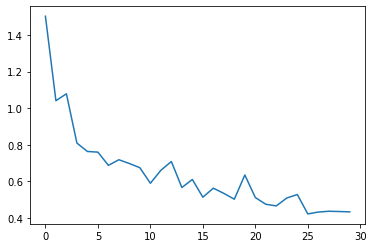

In [ ]:
plt.plot(all_test_losses)

In [ ]:
for epoch in range(epochs):
    train(train_loader, n_classes, model, named_params,epoch,optimizer)   

    reset_named_params(named_params)


    test_loss, acc1 = test( model, test_loader )


    scheduler.step()

        
    # remember best acc@1 and save checkpoint
    is_best = acc1 > best_acc1
    best_acc1 = max(acc1, best_acc1)
        
    # save_checkpoint({
    #         'epoch': epoch + 1,
    #         'state_dict': model.state_dict(),
    #         #'oracle_state_dict': oracle.state_dict(),
    #         'best_acc1': best_acc1,
    #         'optimizer' : optimizer.state_dict(),
    #         #'oracle_optimizer' : oracle_optim.state_dict(),
    #     }, is_best, prefix=prefix)

    all_test_losses.append(test_loss)

test_loss, acc1 = test( model, test_loader )

Train Epoch: 0 [25600/60000 (43%)]	lr: 0.001000	Loss: 15.864305	Oracle:                 8.950606	Clf: 6.948392	Reg: -0.034693	Fr: 0.015097
Train Epoch: 0 [51200/60000 (85%)]	lr: 0.001000	Loss: 15.382572	Oracle:                 8.305547	Clf: 7.096578	Reg: -0.019553	Fr: 0.015146

Test set: Average loss: 0.4423, Accuracy: 8676/10000 (87%)

Train Epoch: 1 [25600/60000 (43%)]	lr: 0.001000	Loss: 15.234366	Oracle:                 8.261125	Clf: 6.981818	Reg: -0.008577	Fr: 0.015058
Train Epoch: 1 [51200/60000 (85%)]	lr: 0.001000	Loss: 15.101129	Oracle:                 8.100208	Clf: 7.008394	Reg: -0.007473	Fr: 0.015346

Test set: Average loss: 0.4459, Accuracy: 8645/10000 (86%)

Train Epoch: 2 [25600/60000 (43%)]	lr: 0.001000	Loss: 15.033659	Oracle:                 8.141245	Clf: 6.897549	Reg: -0.005135	Fr: 0.015350
Train Epoch: 2 [51200/60000 (85%)]	lr: 0.001000	Loss: 14.839569	Oracle:                 8.054306	Clf: 6.788871	Reg: -0.003607	Fr: 0.015304

Test set: Average loss: 0.4846, Accuracy: 8

In [ ]:
best_acc1

tensor(86.4300)

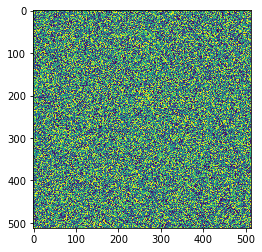

In [ ]:
w = model.network.snn_h.layer1_x.weight.detach().cpu().numpy()
b = model.network.snn_h.layer1_x.bias.detach().cpu().numpy()
plt.imshow(w)

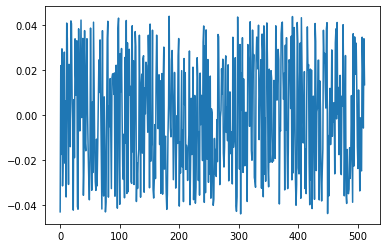

In [ ]:
plt.plot(b)

(array([ 8988., 13455., 13412., 13740., 13820., 13647., 13653., 13454.,
        13533., 13458., 13594., 13719., 13353., 13646., 13605., 13785.,
        13540., 13486., 13488.,  8768.]),
 array([-0.07924857, -0.07131094, -0.06337332, -0.05543569, -0.04749807,
        -0.03956044, -0.03162281, -0.02368519, -0.01574756, -0.00780993,
         0.00012769,  0.00806532,  0.01600294,  0.02394057,  0.0318782 ,
         0.03981582,  0.04775345,  0.05569107,  0.0636287 ,  0.07156633,
         0.07950395], dtype=float32),
 <a list of 20 Patch objects>)

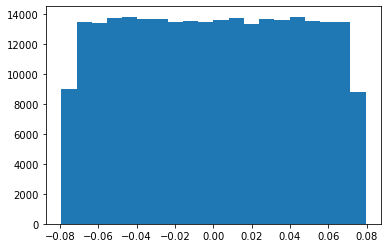

In [ ]:
w = model.network.snn_r.layer1_r.weight.detach().cpu().numpy()
plt.hist(w.reshape(w.shape[0]*w.shape[1]),bins=20)
# plt.hist(w_init.reshape(w.shape[0]*w.shape[1]),bins=20,alpha=0.5)

(array([4.000e+00, 2.300e+01, 9.600e+01, 3.480e+02, 2.025e+03, 4.735e+03,
        5.170e+03, 5.289e+03, 5.321e+03, 5.327e+03, 5.304e+03, 5.221e+03,
        5.142e+03, 4.731e+03, 2.013e+03, 3.360e+02, 9.400e+01, 1.300e+01,
        7.000e+00, 1.000e+00]),
 array([-0.19753575, -0.17671423, -0.1558927 , -0.13507117, -0.11424965,
        -0.09342812, -0.07260659, -0.05178507, -0.03096354, -0.01014201,
         0.01067951,  0.03150104,  0.05232257,  0.07314409,  0.09396562,
         0.11478715,  0.13560867,  0.1564302 ,  0.17725173,  0.19807325,
         0.21889478], dtype=float32),
 <a list of 20 Patch objects>)

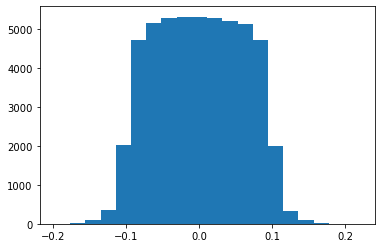

In [ ]:
w = model.network.snn_p.layer1_x.weight.detach().cpu().numpy()
plt.hist(w.reshape(w.shape[0]*w.shape[1]),bins=20)

In [ ]:
for i ,(data, target) in enumerate(test_loader):
    x = data
    break
x.mean(),x.var(),x.min(),x.max()

(tensor(-0.4145), tensor(0.5122), tensor(-1.), tensor(1.))